### Italia Telecom Internet Traffic Activity Forecast for Milano City


### Introduction:
##### Italia Telecom release an open source data set that contains the Call, SMS, Internet activity per sqaure ID in 10 minutes time series collected as a result of a computation over the Call Detail Records (CDRs) generated by the Telecom Italia cellular network over the city of Milano.
##### This data set will be used in this project to build a time series deep learning model using LSTM Nueral Network to forecast the internet activity for the milano city.
##### The discription of the data set can be found in this link: https://dandelion.eu/datagems/SpazioDati/telecom-sms-call-internet-mi/description/

### Extract Transform Load (ETL) Process, Data Exploration , Data Cleansing and Feature Creation:
##### The data set is a structured relational data and stored in a tsv format and can be found in the link: https://dandelion.eu/datagems/SpazioDati/telecom-sms-call-internet-mi/resource/
##### a description of the schema is as documented in the link have the following description of features:
"Schema
 

Square id: the id of the square that is part of the Milano GRID; TYPE: numeric
Time interval: the beginning of the time interval expressed as the number of millisecond elapsed from the Unix Epoch on January 1st, 1970 at UTC. The end of the time interval can be obtained by adding 600000 milliseconds (10 minutes) to this value. TYPE: numeric
Country code: the phone country code of a nation. Depending on the measured activity this value assumes different meanings that are explained later. TYPE: numeric
SMS-in activity: the activity in terms of received SMS inside the Square id, during the Time interval and sent from the nation identified by the Country code. TYPE: numeric
SMS-out activity: the activity in terms of sent SMS inside the Square id, during the Time interval and received by the nation identified by the Country code. TYPE: numeric
Call-in activity: the activity in terms of received calls inside the Square id, during the Time interval and issued from the nation identified by the Country code. TYPE: numeric
Call-out activity: the activity in terms of issued calls inside the Square id, during the Time interval and received by the nation identified by the Country code. TYPE: numeric
Internet traffic activity: the activity in terms of performed internet traffic inside the Square id, during the Time interval and by the nation of the users performing the connection identified by the Country code . TYPE: numeric
 

Important notes
Files are in tsv format. If no activity was recorded for a field specified in the schema above then the corresponding value is missing from the file. For example, if for a given combination of the Square id s, the Time interval i and the Country code c no SMS was sent the corresponding record looks as follows:

s \t i \t c \t \t SMSout \t Callin \t Callout \t Internettraffic

where \t corresponds to the tab character, SMSout is the value corresponding to the SMS-out activity, Callin is the value corresponding to the Call-in activity, Callout is the value corresponding to the Call-out activity and internettraffic is the value corresponding to the  Internet traffic activity.

Moreover, if for a given combination of the Square id s, the Time interval i and the Country code c no activity is recorded the corresponding record is missing from the dataset. This means that records of the following type

s \t i \t c \t \t \t \t \t

are not stored in the dataset"

##### The last paragraph mentions that if no SMS, Call, Internet activity is found for a certain ( Square ID, Time Interval, Country Code ), it is not included in the data set and that means we don't have to do this step as part of the data cleansing process.

##### The data source contain multiple files where each file represent the telecom activity for a certain data in range from November 01, 2013 till December 31, 2013.
##### Another two compressed files includes all the daily records files, where one of them represent all the daily files for November 2013 and the one all the daily files for December 2013.
##### To download the file a registration in the https://dandelion.eu website is required. and after that download links can be made available a few minutes session, therefore we need to update the download link each time we need to access it.
##### Let's start by download the data for November 01, 2013 and look at the data before continuing with ETL process for a whole month.


In [ ]:
# wget command to download the data for November 1st.
wget -O telco_Nov_01.zip http://dl.dandelion.eu/OXdeYYyP0-H82IslWvyh-g/1555928426/jaradat.alaa%40yahoo.com/telecom-sms-call-internet-mi/sms-call-internet-mi-2013-11-01.zip

##### Extract the downloaded zip file in the same directory

In [6]:
import zipfile
zip_ref = zipfile.ZipFile("telco_Nov_01.zip", 'r')
zip_ref.extractall()
zip_ref.close()

##### Load the file in a pandas data frame and check its contents

In [7]:
import pandas as pd
df = pd.read_csv("sms-call-internet-mi-2013-11-01.txt", index_col=None, header=None, sep='\t')
df.head()

,0,1,2,3,4,5,6,7
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963


##### Rename the columns to understand the data

In [8]:
df.columns = ['Square_ID','Time_Interval', 'Country_Code', 'SMS_in_Activity', 'SMS_out_Activity', 'Call_in_Activity', 'Call_out_Activity', 'Internet_Traffic_Activity']
df.head()

,Square_ID,Time_Interval,Country_Code,SMS_in_Activity,SMS_out_Activity,Call_in_Activity,Call_out_Activity,Internet_Traffic_Activity
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963


##### Let's check the data types of the features:

In [9]:
df.dtypes

Square_ID                      int64
Time_Interval                  int64
Country_Code                   int64
SMS_in_Activity              float64
SMS_out_Activity             float64
Call_in_Activity             float64
Call_out_Activity            float64
Internet_Traffic_Activity    float64
dtype: object

##### The Sqare IDs are in teh Range from 1 to 9999 where each square represents a geographical square location as described in the Milano grid link:
##### https://dandelion.eu/datagems/SpazioDati/milano-grid/description/

In [10]:
df['Square_ID'].unique()

array([   1,   10,  100, ..., 9997, 9998, 9999], dtype=int64)

##### The time interval has this description:
"Time interval: the beginning of the time interval expressed as the number of millisecond elapsed from the Unix Epoch on January 1st, 1970 at UTC. The end of the time interval can be obtained by adding 600000 milliseconds (10 minutes) to this value. TYPE: numeric"
##### And to make this field readable to us we can convert those milliseconds to date/time type and shift the time by one hour to consider the time zone difference between UTC and Milano City.

In [11]:
df['DT'] = pd.to_datetime(df['Time_Interval'], unit='ms')
df.DT = df.DT + pd.Timedelta('01:00:00')
df.head()

,Square_ID,Time_Interval,Country_Code,SMS_in_Activity,SMS_out_Activity,Call_in_Activity,Call_out_Activity,Internet_Traffic_Activity,DT
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN,2013-11-01 00:00:00
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366,2013-11-01 00:00:00
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN,2013-11-01 00:10:00
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137,2013-11-01 00:10:00
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963,2013-11-01 00:10:00


##### For this use-case we are only interested in the Internet traffic activity for the whole city
##### Let's drop the not necessary columns

In [12]:
df = df.drop(columns=['Square_ID', 'Time_Interval', 'Country_Code', 'SMS_in_Activity', 'SMS_out_Activity', 'Call_in_Activity', 'Call_out_Activity'])
df.head()

,Internet_Traffic_Activity,DT
0,NaN,2013-11-01 00:00:00
1,11.028366,2013-11-01 00:00:00
2,NaN,2013-11-01 00:10:00
3,0.026137,2013-11-01 00:10:00
4,11.100963,2013-11-01 00:10:00


##### From the description of the data source, we know that NaN values denotes that there were no activity at the given (Sqaure ID, Time Interval, Country Code)
##### Let's fill the NaNs with 0s.

In [13]:
df = df.fillna(0)
df.head()

,Internet_Traffic_Activity,DT
0,0.000000,2013-11-01 00:00:00
1,11.028366,2013-11-01 00:00:00
2,0.000000,2013-11-01 00:10:00
3,0.026137,2013-11-01 00:10:00
4,11.100963,2013-11-01 00:10:00


##### Now we can sum the internet traffic activity for each time interval using group by.

In [14]:
df = df.groupby(['DT']).sum()
df.head()

,Internet_Traffic_Activity
DT,
2013-11-01 00:00:00,642388.341222
2013-11-01 00:10:00,630005.148721
2013-11-01 00:20:00,619933.182580
2013-11-01 00:30:00,590963.037909
2013-11-01 00:40:00,577130.081608


##### To construst time series we need to make sure the all 10 minutes intervals exists in the data set.
##### The day have 24 Hours and each Hour have 6 time interval of 10 minutes, therefore 1 Day Have ( 6*24 ) = 144 time intevals of 10 minutes.

In [15]:
df.shape

(144, 1)

##### Now that we extracted, tranformed, cleaned one data file, let's extract the results for the whole month of november 2013
##### To do that we will do the following steps:
##### 1) download the zipped file for November 2013
##### 2) Extract the downloaded file to a folder ( telco )
##### 3) import glob library to find all the pathnames matching a specified pattern which is in this case "/*.txt"
##### 4) create an empty list to hold the extracted data from each file
##### 5) create a for loop to loop thorugh each file in the glob object
#####     5.1 ) read the csv file into a pandas data frame
#####     5.2 ) rename the columns
#####     5.3 ) convert the Time_Interval from milliseconds to date/time format and shift the timezone by hour
#####     5.4 ) drop the not necessary columns
#####     5.5 ) replace NaN values with 0s
#####     5.6 ) sum internet traffic acitivity for each 10 minutes time interval
#####     5.7 ) reset the index to be able to concatenate the result with other results
#####     5.8 ) append the dataframe to created list
#####     5.9 ) repeat steps 5.1 to 5.9 until for loop exits
##### 6) use pandas concat method to consruct the data frame from list that holds the results for all days of november 2013

In [ ]:
# Download the November 2013 data file
!wget -O telco_Nov.zip http://dl.dandelion.eu/lVviidgD_x5h5yF6HsaFbQ/1555911006/jaradat.alaa%40yahoo.com/telecom-sms-call-internet-mi/november/full.zip

In [69]:
#Extract the downloaded file
#import zipfile
#zip_ref = zipfile.ZipFile("telco_Nov.zip", 'r')
#zip_ref.extractall("telco/")
#zip_ref.close()

#import glob library to to find all the pathnames matching a specified pattern which is in this case "/*.txt"
#import pandas as pd
import glob
path = r'./telco' # use your path
all_files = glob.glob(path + "/*.txt")

# create an empty list to hold the extracted data from each file
li = []

# loop through all the files to extract the results to created list 
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None, sep='\t')
    df.columns = ['Square_ID','Time_Interval', 'Country_Code', 'SMS_in_Activity', 'SMS_out_Activity', 'Call_in_Activity', 'Call_out_Activity', 'Internet_Traffic_Activity']
    df['DT'] = pd.to_datetime(df['Time_Interval'], unit='ms')
    df.DT = df.DT + pd.Timedelta('01:00:00')
    df = df.drop(columns=['Square_ID', 'Time_Interval', 'Country_Code', 'SMS_in_Activity', 'SMS_out_Activity', 'Call_in_Activity', 'Call_out_Activity'])
    df = df.fillna(0)
    df = df.groupby(['DT']).sum()
    df = df.reset_index()
    print( 'Finished Processing ', filename )
    #print(df.head())
    li.append(df)

# convert the list to pandas data frame
df = pd.concat(li, axis=0, ignore_index=True)
df.head()

Finished Processing  ./telco\sms-call-internet-mi-2013-11-01.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-02.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-03.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-04.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-05.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-06.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-07.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-08.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-09.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-10.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-11.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-12.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-13.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-14.txt
Finished Processing  ./telco\sms-call-internet-mi-2013-11-15.txt
Finished Processing  ./te

,DT,Internet_Traffic_Activity
0,2013-11-01 00:00:00,642388.341222
1,2013-11-01 00:10:00,630005.148721
2,2013-11-01 00:20:00,619933.182580
3,2013-11-01 00:30:00,590963.037909
4,2013-11-01 00:40:00,577130.081608


##### Directory listing just to see the extracted files.

In [14]:
ls telco/

sms-call-internet-mi-2013-11-01.txt  sms-call-internet-mi-2013-11-16.txt
sms-call-internet-mi-2013-11-02.txt  sms-call-internet-mi-2013-11-17.txt
sms-call-internet-mi-2013-11-03.txt  sms-call-internet-mi-2013-11-18.txt
sms-call-internet-mi-2013-11-04.txt  sms-call-internet-mi-2013-11-19.txt
sms-call-internet-mi-2013-11-05.txt  sms-call-internet-mi-2013-11-20.txt
sms-call-internet-mi-2013-11-06.txt  sms-call-internet-mi-2013-11-21.txt
sms-call-internet-mi-2013-11-07.txt  sms-call-internet-mi-2013-11-22.txt
sms-call-internet-mi-2013-11-08.txt  sms-call-internet-mi-2013-11-23.txt
sms-call-internet-mi-2013-11-09.txt  sms-call-internet-mi-2013-11-24.txt
sms-call-internet-mi-2013-11-10.txt  sms-call-internet-mi-2013-11-25.txt
sms-call-internet-mi-2013-11-11.txt  sms-call-internet-mi-2013-11-26.txt
sms-call-internet-mi-2013-11-12.txt  sms-call-internet-mi-2013-11-27.txt
sms-call-internet-mi-2013-11-13.txt  sms-call-internet-mi-2013-11-28.txt
sms-call-internet-mi-2013-11-14.txt  sms-call-inter

##### Explore the result data sest that contains internet traffic activity for the Milano city for each 10 minutes time interval in november 2013

In [70]:
# check the data frame object type
print( "Type of the dataframe object: " , type(df), '\n' )

# check the columns data types
print( "Column data types: ", df.dtypes , '\n' )

# check the dimensions of the data frame
print( "Data frame dimensions: ", df.shape , '\n ')

# do we have 144 records for all the 30 days in November ?
# if the result of dividing the records count by 30 equals 144 it means that our data set is ready to be converted to time series.
print( "Do we have 144 * 30 records in our data set ? " , df.DT.count() , '/ 30 = ' , df.DT.count() / 30 )

Type of the dataframe object:  <class 'pandas.core.frame.DataFrame'> 

Column data types:  DT                           datetime64[ns]
Internet_Traffic_Activity           float64
dtype: object 

Data frame dimensions:  (4320, 2) 
 
Do we have 144 * 30 records in our data set ?  4320 / 30 =  144.0


##### Visualize the data to figure our the relations intuitively

In [71]:
# matplolib library to plot the data set, with matplotlib inline command to allow us render the plot using Jupyter notebook.
import matplotlib.pyplot as plt
%matplotlib inline

##### By visualizing all the data frame in one plot we can see how internet traffic activity is running in each day 
##### We can also see seasonality componets ( e.g. internet traffic during weekends is less than working days )

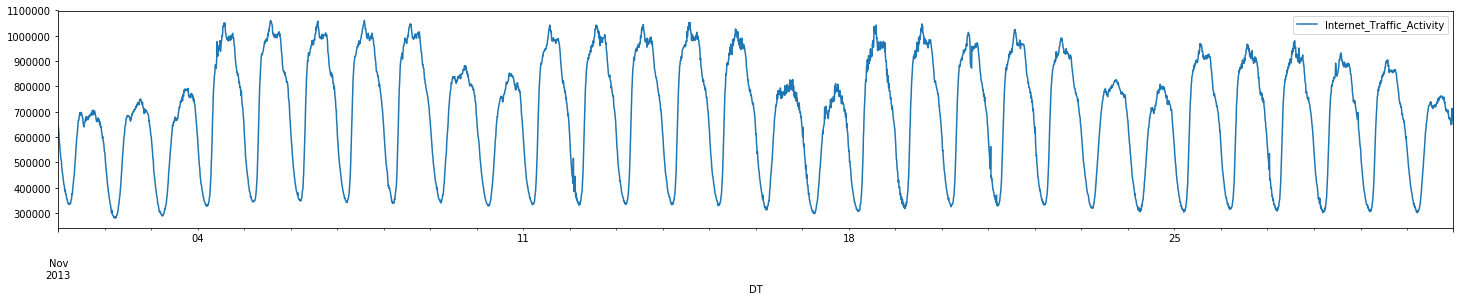

In [72]:
df.plot(x='DT', y='Internet_Traffic_Activity', figsize=(25, 4) )

##### By Visualizing one day we can see that internet traffic is at highest level from 9:00 to 21:00 ( usually higher because day time )
##### Internet traffic is at lowest level from 3:00 AM to 7:00 ( Most people are sleeping at this time )

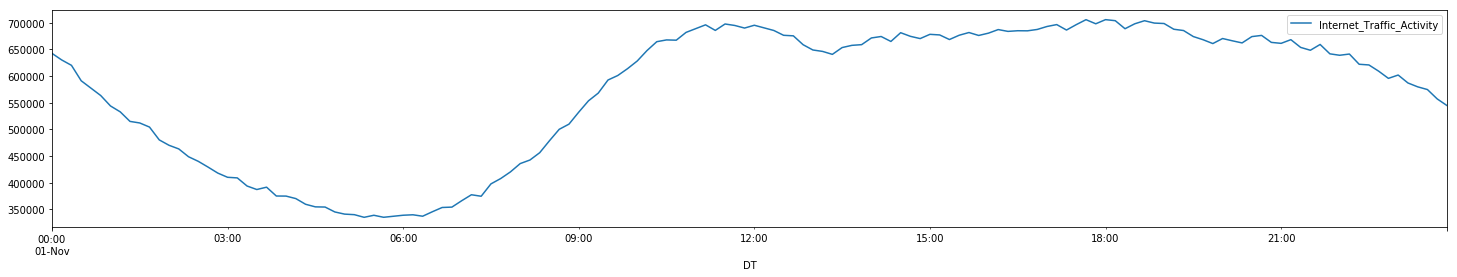

In [73]:
df[:144].plot( x='DT', y='Internet_Traffic_Activity', figsize=(25, 4) )

##### Investigate the Internet traffic feature numerically using pandas describe method:

In [74]:
df.describe()

,Internet_Traffic_Activity
count,4.320000e+03
mean,6.904371e+05
std,2.286881e+05
min,2.807344e+05
25%,4.633652e+05
50%,7.342948e+05
75%,8.904611e+05
max,1.059773e+06


###### Box plot can be much more intuitive and easier to understand for the internet activity feature
###### Min of around 280,000
###### Median of around 730,000
###### Max of around 1,050,000

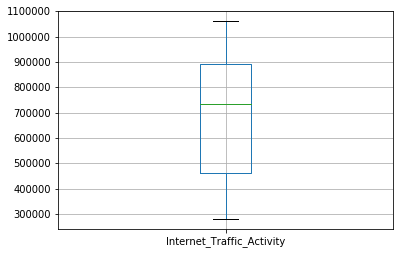

In [75]:
df.boxplot()

##### Let's look at how the internet traffic is distributed 
##### Keep in mind that from 9:00 to 21:00 ( which is half of the day ) the intenet activity is at a high level
##### 350,000 is usually the intenet traffic from 4:00 to 7:00
##### around 700,000 the high traffic during weekends
##### around 1,000,000 the high traffic during workdays
##### despite the shape doesn't look like normal curve, but it describes the data logically and in other words correclty

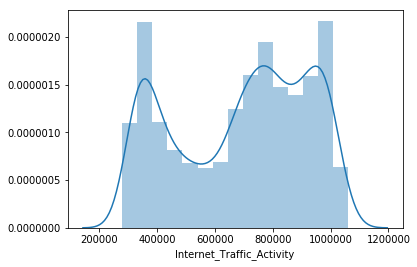

In [76]:
# Using seaborn library to draw the distribution
import seaborn as sns
sns.distplot(df['Internet_Traffic_Activity'])

##### And let's see how the internet traffic is distributed for the first day of November 2013

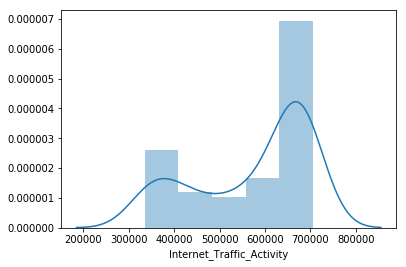

In [77]:
df_Nov_01 = df[:144]
sns.distplot(df_Nov_01['Internet_Traffic_Activity'])

### Model Definition

##### Now that we have the internet traffic activity time series ready as a result of the ETL, Data Cleansing and Feature Engineering processing
##### We can start building models to be able to forecast the internet traffic activity.
##### Time series forecasting can be achieved by many algorithms and i have selected the deep learning LSTM Neural Network and the ARIMA algorithm to build this model.
##### To be able to evaluate the model accurary we will split our into training set and test set.
##### The trainsing set size is 90% of the data and test set size is 10% of the data which is around 3 days in this use case.
##### For the model evaluation we will use rmse which stands for Root Mean Sqaured Error and mae which stands for Mean Absolute Error.
##### The model that we will build will be later compared by rmse and mae to select the model with best performance for this data set.
##### We will start by building the deep learning LSTM Neural Network.
##### Let's start by importing the libraries required to build the LSTM model.

In [25]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


##### I have selected batch size of 6 and timesteps of 6 and the number epochs for training as 20 epochs.

In [78]:
# defining the batch size and number of epochs
batch_size = 6
epochs = 20
timesteps = 6

#### Model training
##### The total records in the data frame are 4320 and training set size is 3888.

In [79]:
length = len(df)
print(length)
length *= 1 - 0.1
print(length)

4320
3888.0


##### The LSTM NN expects a training set size that is divisible by the batch size and luckily in our case 3888 is divisible by the batch size.

In [80]:
print( "Data frame size / Batch size = " , length / batch_size )
print( "Data frame size % Batch size = " , length % batch_size )

Data frame size / Batch size =  648.0
Data frame size % Batch size =  0.0


##### training set is initially 3888 But we becuase teh timesteps we selected is 6 we will use 6 time steps to training set for training and 6 time steps to forecast by adding timesteps*2 to the training set size.

In [81]:
upper_train = length + timesteps*2
upper_train

3900.0

In [82]:
df_train = df[0:3900]
training_set = df_train.iloc[:,1:2].values
print ( "Training set shape with all features: " , df_train.shape )
print ( "Training set shape with only Internet traffic feature: ",  training_set.shape )
print ( "Training set first five elements: ")
print ( training_set[0:5] )

Training set shape with all features:  (3900, 2)
Training set shape with only Internet traffic feature:  (3900, 1)
Training set first five elements: 
[[642388.34122185]
 [630005.14872086]
 [619933.18257961]
 [590963.03790876]
 [577130.08160794]]


##### LSTM gives better predictions when scaling the feature to values between 0 and 1. 
##### MinMaxScaler of sklearn library is used here to scale the internet traffic activity feature to be between 0 and 1.

In [83]:
# Feature Scaling
#scale between 0 and 1. the weights are esier to find.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(3900, 1)

In [86]:
training_set_scaled[0:5]

array([[0.46423114],
       [0.44833566],
       [0.43540694],
       [0.3982199 ],
       [0.38046345]])

##### To use the length variable we created in the range of a for loop we need to convert it to int instead of float.

In [91]:
length = int( length )
print( type(length) )
print( length )

<class 'int'>
3888


##### Training set and test set are transformed to a data structures with 6 timesteps which is here a list of arrays were each array contains 6 observations of the internet traffic activity feature.

In [93]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print("length + timesteps: ",  length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print("length of X_train: " , len(X_train))
print("length of y_train: " , len(y_train))
#create X_train matrix
#6 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#6 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

length + timesteps:  3894
length of X_train:  3888
length of y_train:  3888
[array([0.46423114, 0.44833566, 0.43540694, 0.3982199 , 0.38046345,
       0.36270228]), array([0.44833566, 0.43540694, 0.3982199 , 0.38046345, 0.36270228,
       0.33765119])]
(3888, 6)
[array([0.33765119, 0.32343921, 0.30045709, 0.29669548, 0.28680282,
       0.25595089]), array([0.32343921, 0.30045709, 0.29669548, 0.28680282, 0.25595089,
       0.24299058])]
(3888, 6)


##### Keras requires three dimensions for the input and output, and we will reshape the X_train and y_train sets.

In [94]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_train first 5 observations: " , X_train[0:5])
print("y_train first 5 observations: ", y_train[0:5])

X_train shape:  (3888, 6, 1)
y_train shape:  (3888, 6, 1)
X_train first 5 observations:  [[[0.46423114]
  [0.44833566]
  [0.43540694]
  [0.3982199 ]
  [0.38046345]
  [0.36270228]]

 [[0.44833566]
  [0.43540694]
  [0.3982199 ]
  [0.38046345]
  [0.36270228]
  [0.33765119]]

 [[0.43540694]
  [0.3982199 ]
  [0.38046345]
  [0.36270228]
  [0.33765119]
  [0.32343921]]

 [[0.3982199 ]
  [0.38046345]
  [0.36270228]
  [0.33765119]
  [0.32343921]
  [0.30045709]]

 [[0.38046345]
  [0.36270228]
  [0.33765119]
  [0.32343921]
  [0.30045709]
  [0.29669548]]]
y_train first 5 observations:  [[[0.33765119]
  [0.32343921]
  [0.30045709]
  [0.29669548]
  [0.28680282]
  [0.25595089]]

 [[0.32343921]
  [0.30045709]
  [0.29669548]
  [0.28680282]
  [0.25595089]
  [0.24299058]]

 [[0.30045709]
  [0.29669548]
  [0.28680282]
  [0.25595089]
  [0.24299058]
  [0.23422365]]

 [[0.29669548]
  [0.28680282]
  [0.25595089]
  [0.24299058]
  [0.23422365]
  [0.21543535]]

 [[0.28680282]
  [0.25595089]
  [0.24299058]
  [0.23

##### Now that we prepared our data for keras LSTM NN, we will start building.
##### The following libraries are required:

In [95]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

##### Building the LSTM model with following parameters:
##### Loss-Function: MAE
##### Batch size : 6
##### Time steps: 6
##### Number of dimension: 1
##### LSTM type: Stateful
##### Hidden Layer 1: 24
##### Hidden Layer 2: 24
##### Optimizer: adam

In [96]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(24, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(24, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (6, 6, 1)                 0         
_________________________________________________________________
lstm_1 (LSTM)                (6, 6, 24)                2496      
_________________________________________________________________
lstm_2 (LSTM)                (6, 6, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (6, 6, 1)                 25        
Total params: 7,225
Trainable params: 7,225
Non-trainable params: 0
_________________________________________________________________


### Model Training
##### A for loop to repeat fitting the model with of the number epochs that we selected wich is 20

In [97]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch: 0
Epoch 1/1
3888/3888 [==============================] - 6s 2ms/step - loss: 0.1567
Epoch: 1
Epoch 1/1
3888/3888 [==============================] - 3s 871us/step - loss: 0.1162
Epoch: 2
Epoch 1/1
3888/3888 [==============================] - 3s 863us/step - loss: 0.0949
Epoch: 3
Epoch 1/1
3888/3888 [==============================] - 3s 875us/step - loss: 0.0817
Epoch: 4
Epoch 1/1
3888/3888 [==============================] - 3s 887us/step - loss: 0.0740
Epoch: 5
Epoch 1/1
3888/3888 [==============================] - 5s 1ms/step - loss: 0.0655
Epoch: 6
Epoch 1/1
3888/3888 [==============================] - 5s 1ms/step - loss: 0.0622
Epoch: 7
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0560
Epoch: 8
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0569
Epoch: 9
Epoch 1/1
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0584
Epoch: 10
Epoch 1/1
3888/3888 [==============================] - 5s 1ms/step - los

##### After training the LSTM model we will save the model and load it back using h5py library.

In [99]:
#save model
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

#load model
import h5py
regressor_mae = load_model(filepath="my_model_with_mae_30_ts.h5")

##### We will get the test set length. and it will be 402 time interval and it is around three days.

In [114]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 350, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [115]:
test_length = get_test_length(df, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

3972
3978
3984
3990
3996
4002
4008
4014
4020
4026
4032
4038
4044
4050
4056
4062
4068
4074
4080
4086
4092
4098
4104
4110
4116
4122
4128
4134
4140
4146
4152
4158
4164
4170
4176
4182
4188
4194
4200
4206
4212
4218
4224
4230
4236
4242
4248
4254
4260
4266
4272
4278
4284
4290
4296
4302
4302
402


In [116]:
print("Upper train: ", upper_train) 
print("Upper test: ", upper_test)
print("length of original data frame: ", len(df))

Upper train:  3900
Upper test:  4314
length of original data frame:  4320


In [117]:
# Convert the upper_train & testset_length from float to integer
upper_train = int(upper_train)
testset_length = int( testset_length )

##### After deciding the boudaries for the test set, we have to do some preprocessing to make test set ready for prediction.

In [120]:
# construct test set

#subsetting
df_test = df[upper_train:upper_test]
print( "df_test" )
print( df_test.head() )
test_set = df_test.iloc[:,1:2].values
print( "\ntest_set" )
print( test_set[0:5] )

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))
print( "\nscaled_real_bcg_values_test")
print( scaled_real_bcg_values_test[0:5] )

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print( "\nXtest: ")
print( X_test[0:5] )

df_test
                      DT  Internet_Traffic_Activity
3900 2013-11-28 02:00:00              383633.646122
3901 2013-11-28 02:10:00              361113.818499
3902 2013-11-28 02:20:00              355242.264198
3903 2013-11-28 02:30:00              361153.227415
3904 2013-11-28 02:40:00              353044.006029

test_set
[[383633.64612168]
 [361113.81849904]
 [355242.26419761]
 [361153.2274151 ]
 [353044.00602865]]

scaled_real_bcg_values_test
[[0.12946517]
 [0.09369809]
 [0.08437261]
 [0.09376068]
 [0.08088123]]

Xtest: 
[[[0.12946517]
  [0.09369809]
  [0.08437261]
  [0.09376068]
  [0.08088123]
  [0.05749178]]

 [[0.09369809]
  [0.08437261]
  [0.09376068]
  [0.08088123]
  [0.05749178]
  [0.09023953]]

 [[0.08437261]
  [0.09376068]
  [0.08088123]
  [0.05749178]
  [0.09023953]
  [0.07456677]]

 [[0.09376068]
  [0.08088123]
  [0.05749178]
  [0.09023953]
  [0.07456677]
  [0.0429997 ]]

 [[0.08088123]
  [0.05749178]
  [0.09023953]
  [0.07456677]
  [0.0429997 ]
  [0.02777293]]]


##### Just to verify the shape of X_test that it has 3 dimension so it can be used for prediction by our LSTM model.

In [121]:
X_test.shape

(402, 6, 1)

##### Now we use Model to predict the values of test set using our LSTM model.

In [124]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)

regressor_mae.reset_states()

print("predicted_bcg_values_test_mae shape: ", predicted_bcg_values_test_mae.shape)
predicted_bcg_values_test_mae[0:5]

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print("\npredicted_bcg_values_test_mae after reshaping: ", predicted_bcg_values_test_mae.shape)
print( predicted_bcg_values_test_mae )

#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)
print( "\npredicted_bcg_values_test_mae after inverse transform: ")
print( predicted_bcg_values_test_mae[0:5])

#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print( "\ny_test shape: ", y_test.shape)
print( y_test[0:5] )

predicted_bcg_values_test_mae shape:  (402, 6, 1)

predicted_bcg_values_test_mae after reshaping:  (402, 6)
[[-0.06706838 -0.12584418 -0.09922381 -0.03740676  0.01104712  0.03316666]
 [-0.09524059 -0.1472904  -0.10026269 -0.0403273  -0.00419668  0.04380958]
 [-0.10227959 -0.14544733 -0.10454585 -0.05642788  0.003128    0.04309006]
 ...
 [ 0.579171    0.5854298   0.5752105   0.5678674   0.58800614  0.56647   ]
 [ 0.5854298   0.5752104   0.5678672   0.5880061   0.56647     0.53760445]
 [ 0.57521045  0.5678673   0.58800614  0.56647     0.5376044   0.5150858 ]]

predicted_bcg_values_test_mae after inverse transform: 
[[259891.33 222884.66 239645.48 278567.   309074.75 323001.75]
 [242153.42 209381.6  238991.38 276728.16 299476.88 329702.8 ]
 [237721.48 210542.03 236294.6  266590.84 304088.7  329249.78]
 [242183.42 208043.39 225584.52 270499.   303648.75 315648.7 ]
 [236082.38 195923.03 230520.84 271506.16 292361.44 301182.53]]

y_test shape:  (396, 1)
[[323001.75   ]
 [329702.8125 ]
 [3292

##### By visualizing the actual and predicted internet traffic activity observation for the last 3 days in 2013 we can see that our LSTM done a good job in prediction.

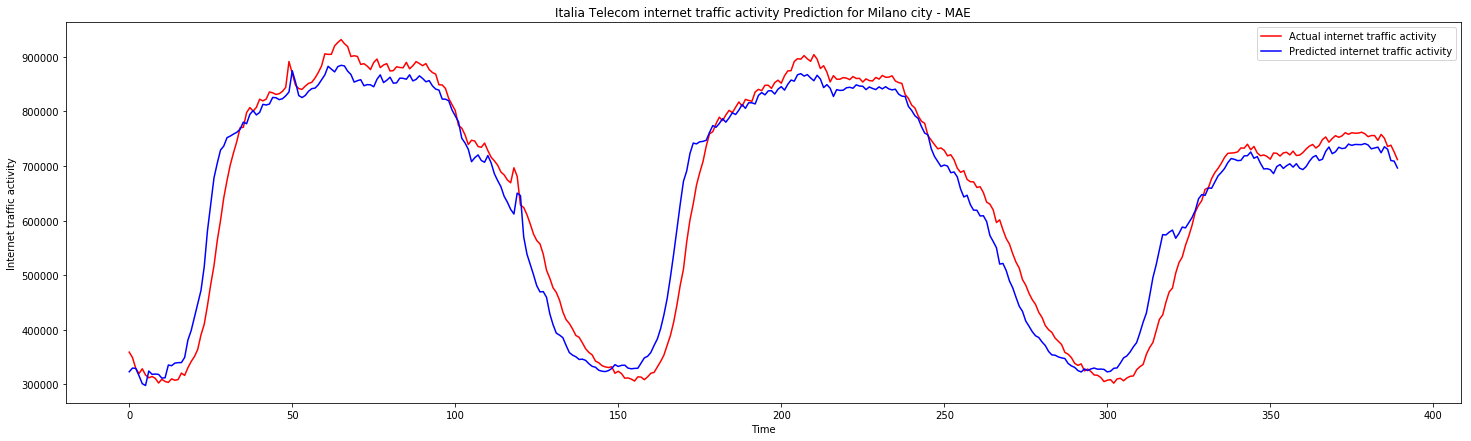

In [127]:
# Visualising the results
plt.figure(figsize=(25,7))
#df.plot(x='DT', y='Internet_Traffic_Activity')
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Actual internet traffic activity')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted internet traffic activity')
plt.title('Italia Telecom internet traffic activity Prediction for Milano city - MAE')
plt.xlabel('Time')
plt.ylabel('Internet traffic activity')
plt.legend()
plt.show()

### Model Evaluation:
##### Using sklearn.metrics library we can compute the rmse and mae errors which will allow evaluate our model performance and compare it with models for ths use caes.

In [132]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print("rmse error: ", rmse)

rmse error:  45000.19788625938


In [133]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print("mae error: ", mae)

mae error:  33393.78948110062


##### Let's check build the second model which is the same LSTM model but with MSE Loss function instead of MAE.
##### we can easily repeat some code blocks that were written for LSTM with MAE for building the LSTM with MST.

##### Buidling the Model: 

In [134]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (6, 6, 1)                 0         
_________________________________________________________________
lstm_3 (LSTM)                (6, 6, 10)                480       
_________________________________________________________________
lstm_4 (LSTM)                (6, 6, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (6, 6, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


##### Train the LSTM with MSE model with 20 epochs.

In [135]:
epochs = 20
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
3888/3888 [==============================] - 7s 2ms/step - loss: 0.0347
Epoch: 1
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0200
Epoch: 2
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0103
Epoch: 3
Epoch 1/1
3888/3888 [==============================] - 4s 985us/step - loss: 0.0081
Epoch: 4
Epoch 1/1
3888/3888 [==============================] - 3s 873us/step - loss: 0.0181
Epoch: 5
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0273
Epoch: 6
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0263
Epoch: 7
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0149
Epoch: 8
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0105
Epoch: 9
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0.0096
Epoch: 10
Epoch 1/1
3888/3888 [==============================] - 4s 1ms/step - loss: 0

##### Save and load the LSTM with MSE model.

In [ ]:
import h5py
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

regressor_mse = load_model(filepath="my_model_with_mse_30_ts.h5")

##### Predict internet traffic activity for the last three days in november 2013

In [136]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

##### And visualize the Predicted Vs. Actual internet traffic activity for the select time interval.

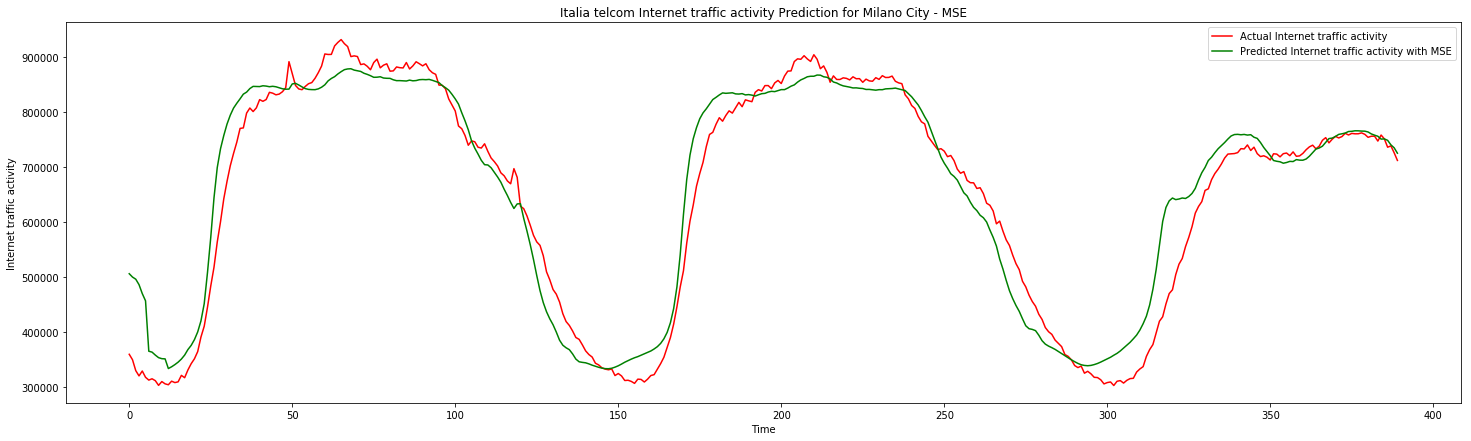

In [138]:
# Visualising the results
plt.figure(figsize=(25,7))
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Actual Internet traffic activity')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Internet traffic activity with MSE')
plt.title('Italia telcom Internet traffic activity Prediction for Milano City - MSE')
plt.xlabel('Time')
plt.ylabel('Internet traffic activity')
plt.legend()

plt.show()

##### Another drawing just to recall the internet traffic activity in the original data set.

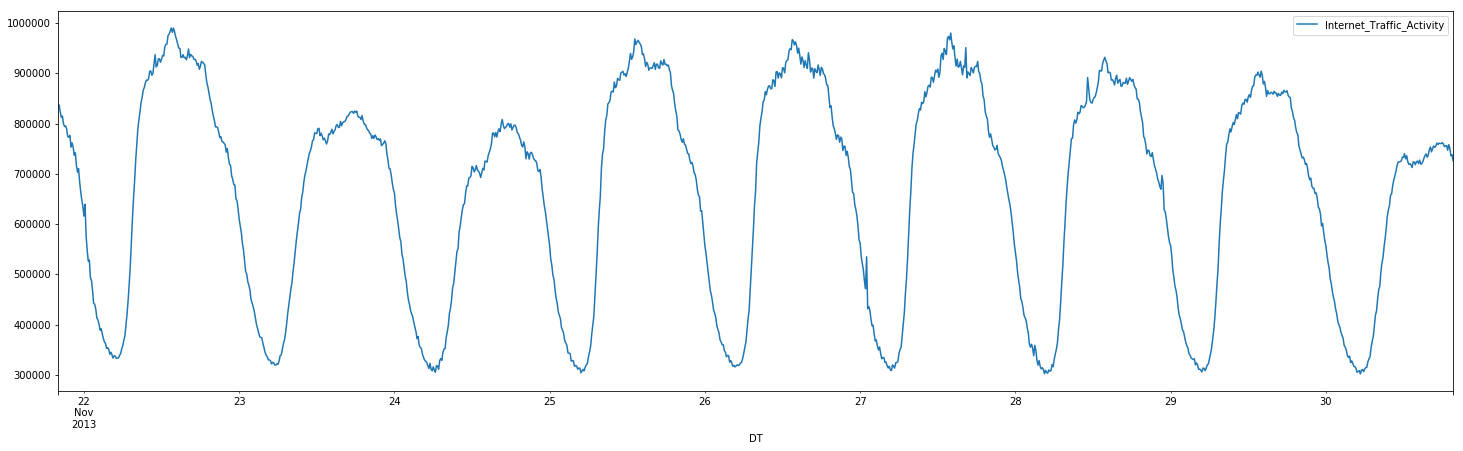

In [139]:
df[3000:4295].plot( x='DT', y='Internet_Traffic_Activity', figsize=(25, 7) )

##### And of course evaluate the model by calculatin the rmse and mae errors.
##### By comparing the two previously created LSTM models, we can see that the LSTM with MAE loss function gave us better results when compared with the LSTM model with MSE loss function.

In [142]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print("rmse: ", rmse)


mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print("mean: ", mean)

mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print("mean: ", mean)


from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print("mae: ", mae)

print( "mea/mean * 100 : ", mae/mean * 100 )

rmse:  49954.952762701294
mean:  648540.7860992886
mean:  648540.7860992886
mae:  36818.50046690152
mea/mean * 100 :  5.677129527712506


##### Let's try another model and this time ARIMA algorithm is selected.
##### ARIMA stands for autoregressive integrated moving average and is mainly used with time series data sets to predict future contineous features.
##### First. we import the statsmodels.tsa.arima_model library and define a funtion to create the model, fit the model, and predict the internet traffic activity for the last 10% observation of our data set which is around 3 days time intervals.
##### The function has four arguments where the first argument is the Actual data and the other arguments are The (p,d,q) which are the order of the ARIMA model. and they are the number of AR parameters, differences, and MA parameters.

In [144]:
from statsmodels.tsa.arima_model import ARIMA

#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

In [156]:
#Size of original data set
NumberOfElements = len(df)
NumberOfElements

4320

##### ARIMA model expects one dimension contained in a list object and in our use case it is the Internet traffic activity feature.

In [157]:
df_arima = df['Internet_Traffic_Activity']
df_arima = df_arima.tolist()
df_arima[0:5]

[642388.3412218541,
 630005.1487208621,
 619933.1825796069,
 590963.0379087586,
 577130.0816079442]

##### Splitting our data to training set (90%) and test set (10%). 

In [158]:
#Use 90% of data as training, rest 10% to Test model
TrainingSize = int(NumberOfElements * 0.9)
TrainingData = df_arima[0:TrainingSize]
TestData = df_arima[TrainingSize:NumberOfElements]
print( "Test set length: ", len(TestData))
print( "\n Training data first five elements: \n", TrainingData[0:5] )
print( "\n Test data first five elements: \n", TestData[0:5] )

Test set length:  432

 Training data first five elements: 
 [642388.3412218541, 630005.1487208621, 619933.1825796069, 590963.0379087586, 577130.0816079442]

 Test data first five elements: 
 [543660.9808723825, 527549.9518355391, 504596.0045360096, 488465.88184693386, 474440.8167317641]


##### Creating an array to store the actual training data and another array to store predicted results.

In [159]:
#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Predictions = list()
print ( "Actual trainng data length: ", len( Actual ) )
print( "Predicted data length: ", len( Predictions ) )
print( "\n Actual training data first 5 elements: \n", Actual[0:5])

Actual trainng data length:  3888
Predicted data length:  0

 Actual training data first 5 elements: 
 [642388.3412218541, 630005.1487208621, 619933.1825796069, 590963.0379087586, 577130.0816079442]


##### Looping through Test data to predict each point in it by calling StartARIMAForcasting function and appending the predicted values to Predictions array.

In [160]:
#in a for loop, predict values using ARIMA model
for timepoint in range(len(TestData)):
    ActualValue =  TestData[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 3,1,0)    
    #print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)

print( "Actual Length: \n", len( Actual ) )
print( "Predicted Length: \n", len( Predictions) )

Actual Length: 
 4320
Predicted Length: 
 432


##### Evaluating the model with rmse and mae errors.

In [163]:
#Print MSE to see how good the model is
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt( mean_squared_error(TestData, Predictions) )
print('rmse: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(TestData, Predictions)
print("mae: ", mae)

rmse: 9207.926
mae:  6476.622809664307


##### By Visualuazing the predicted Vs. actual test data, we can see that they are almost perfectly fit.

<Figure size 1440x504 with 0 Axes>

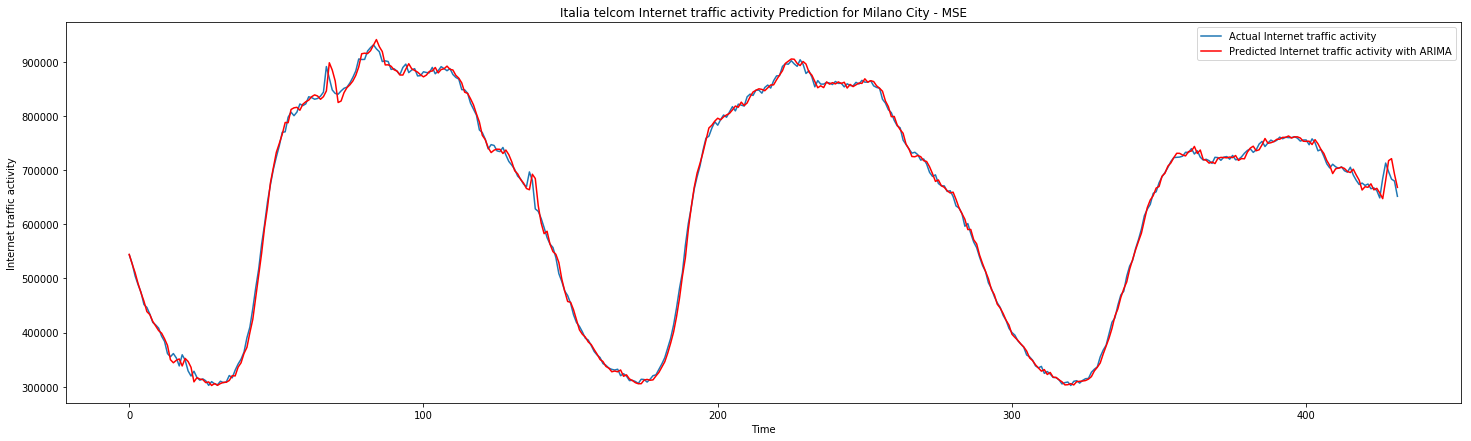

In [172]:
from matplotlib import pyplot
# plot
plt.figure(figsize=(20,7))
# Visualising the results
plt.figure(figsize=(25,7))
plt.title('Italia telcom Internet traffic activity Prediction for Milano City - MSE')
plt.xlabel('Time')
plt.ylabel('Internet traffic activity')
pyplot.plot(TestData, label = 'Actual Internet traffic activity')
pyplot.plot(Predictions, color='red', label = 'Predicted Internet traffic activity with ARIMA')
plt.legend()
pyplot.show()